In [62]:
# IMPORTS
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import warnings

# NLTK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize   
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
warnings.filterwarnings('ignore')

# NLTK RESOURCES
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# VISUALIZATION SETUP
sns.set_style("darkgrid")
sns.set_palette("husl")

[nltk_data] Downloading package punkt to C:\Users\Laptop
[nltk_data]     World\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Laptop
[nltk_data]     World\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Laptop
[nltk_data]     World\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:

df = pd.read_csv(r"C:\Users\Laptop World\Desktop\NLPPROJECT\train.csv")

print("RAWS", len(df))
print("columns", df.columns.tolist())
df.head()

RAWS 120000
columns ['Class Index', 'Title', 'Description']


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


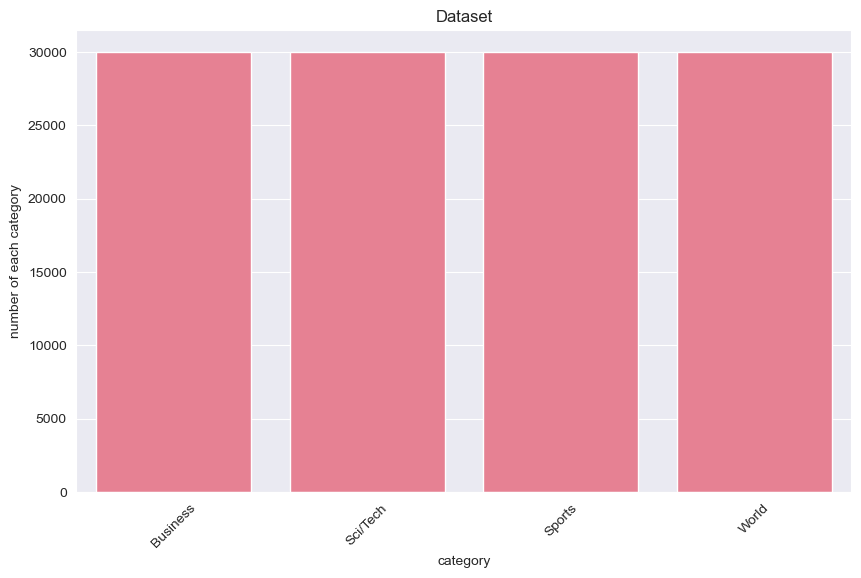

In [64]:
class_names = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
df['Class Name'] = df['Class Index'].map(class_names)

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Class Name', order=df['Class Name'].value_counts().index)
plt.title('Dataset')
plt.xlabel('category')
plt.ylabel('number of each category')
plt.xticks(rotation=45)
plt.show()

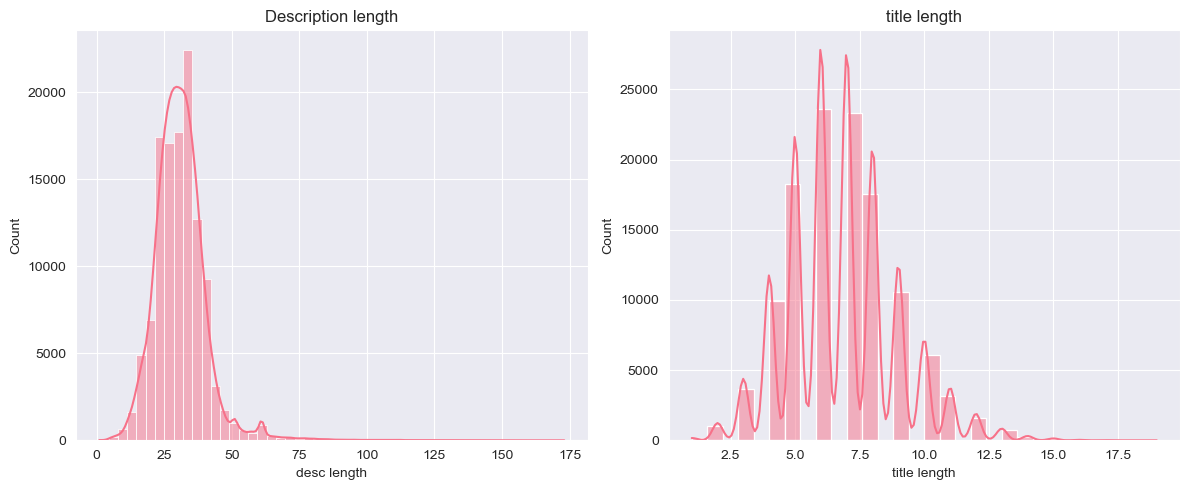

In [65]:

df['desc length'] = df['Description'].apply(lambda x: len(str(x).split()))
df['title length'] = df['Title'].apply(lambda x: len(str(x).split()))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df['desc length'], bins=50, ax=ax1, kde=True)
ax1.set_title('Description length')
sns.histplot(df['title length'], bins=30, ax=ax2, kde=True)
ax2.set_title('title length')
plt.tight_layout()
plt.show()

In [66]:
df['Processed_Description'] = df['Description'].copy()
df['Processed_Title'] = df['Title'].copy()

In [94]:
# 1. LOWERCASE (already done in Processed_Description)
# Assuming you have df with 'Description' and 'Title'
df['Processed_Description'] = df['Description'].astype(str).str.lower()
df['Processed_Title']       = df['Title'].astype(str).str.lower()

print("Lowercase applied")

Lowercase applied


In [95]:
# 2. SEGMENTATION – Split into real sentences
from nltk.tokenize import sent_tokenize

df['Sentences_Description'] = df['Processed_Description'].apply(sent_tokenize)

print(f"Segmentation complete. Avg sentences per description: {df['Sentences_Description'].apply(len).mean():.2f}")

Segmentation complete. Avg sentences per description: 1.28


In [96]:
# 3. REMOVE NUMBERS from each sentence
df['Sentences_Description'] = df['Sentences_Description'].apply(
    lambda sents: [re.sub(r'\d+', '', sent) for sent in sents]
)
print("Numbers removed from sentences")

Numbers removed from sentences


In [97]:
# 4. REMOVE PUNCTUATION from each sentence
df['Sentences_Description'] = df['Sentences_Description'].apply(
    lambda sents: [sent.translate(str.maketrans('', '', string.punctuation)) for sent in sents]
)
print("Punctuation removed from sentences")

Punctuation removed from sentences


In [98]:
# 5. TOKENIZE each sentence into words
df['Tokenized_Sentences'] = df['Sentences_Description'].apply(
    lambda sents: [word_tokenize(sent) for sent in sents]
)
print("Word tokenization done")

Word tokenization done


In [99]:
# 6. REMOVE STOP WORDS
stop_words = set(stopwords.words('english'))

df['Tokenized_Sentences'] = df['Tokenized_Sentences'].apply(
    lambda sents: [[word for word in tokens if word not in stop_words] for tokens in sents]
)
print("Stop words removed")

Stop words removed


In [100]:
# 7. LEMMATIZATION
lemmatizer = WordNetLemmatizer()

df['Tokenized_Sentences'] = df['Tokenized_Sentences'].apply(
    lambda sents: [[lemmatizer.lemmatize(word) for word in tokens] for tokens in sents]
)
print("Lemmatization done")

Lemmatization done


In [101]:
# 8. RE-JOIN tokens into clean sentences (FINAL TEXT)
df['Clean_Sentences'] = df['Tokenized_Sentences'].apply(
    lambda sents: [' '.join(tokens) for tokens in sents]
)

print("Clean sentences ready!")

Clean sentences ready!


In [111]:
# 9. CLEAN TITLE – FULL PIPELINE 

# Ensure we have Processed_Title (lowercased)
df['Processed_Title'] = df['Title'].astype(str).str.lower()

def clean_title(text):
    # 1. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 2. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Tokenize
    tokens = word_tokenize(text)
    
    # 4. Remove stop words (OPTIONAL – set to False if you want to keep them)
    remove_stops = True  # ← غيّر لـ False لو عايز تحتفظ بـ "the", "a", ...
    if remove_stops:
        tokens = [word for word in tokens if word not in stop_words]
    
    # 5. Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # 6. Re-join
    return ' '.join(tokens)

# Apply to all titles
df['Clean_Title'] = df['Processed_Title'].apply(clean_title)

print("Title cleaned")

Title cleaned


In [113]:
# ========================================
# 10. SAVE THE FINAL CLEAN DATA
# ========================================
df_clean = df[['Class Index', 'Clean_Title', 'Clean_Sentences']].copy()
df_clean.to_csv('train_cleaned_with_sentences.csv', index=False)

print("FINAL DATA SAVED → train_cleaned_with_sentences.csv")

FINAL DATA SAVED → train_cleaned_with_sentences.csv


In [115]:
# 11. QUICK VERIFICATION (First 20 descriptions)

print("VERIFICATION: First 20 Cleaned Descriptions")
for idx in range(20):
    print(f"\n[Description {idx}] Class: {df_clean['Class Index'].iloc[idx]}")
    for i, sent in enumerate(df_clean['Clean_Sentences'].iloc[idx], 1):
        print(f"  {i}. {sent}")

VERIFICATION: First 20 Cleaned Descriptions

[Description 0] Class: 3
  1. reuters shortsellers wall street dwindlingband ultracynics seeing green

[Description 1] Class: 3
  1. reuters private investment firm carlyle groupwhich reputation making welltimed occasionallycontroversial play defense industry quietly placedits bet another part market

[Description 2] Class: 3
  1. reuters soaring crude price plus worriesabout economy outlook earnings expected tohang stock market next week depth thesummer doldrums

[Description 3] Class: 3
  1. reuters authority halted oil exportflows main pipeline southern iraq afterintelligence showed rebel militia could strikeinfrastructure oil official said saturday

[Description 4] Class: 3
  1. afp tearaway world oil price toppling record straining wallet present new economic menace barely three month u presidential election

[Description 5] Class: 3
  1. reuters stock ended slightly higher fridaybut stayed near low year oil price surged past barrel off

In [109]:
####دا الترتيب اللي مشينا عليه في النوتبوك دي 

→ Lowercase 
→ Segmentation (sent_tokenize)
→ Remove numbers
→ Remove punctuation
→ Tokenize
→ Remove stop words
→ Lemmatize
→ Re-join → Clean_Sentences
→ SAVE



SyntaxError: unterminated string literal (detected at line 12) (2658251497.py, line 12)